# Terzaghi's consolidation problem

* Author: Jhabriel Varela
* E-mail: jhabriel.varela@uib.no
* Date: 04.04.2019
* Institution: PMG - UiB - Norway

## Description of the problem

Terzaghi's problem is well known one-dimensional consolidation process [[1](#ref)], [[2](#ref)]. Generally, when soils are subjected to a vertical load, porosity decreases, resulting in less available space for the pore water. The water within the pores can be expelled, however, in certain types of soils (especially clayey soils) this process may take some time due to their low permeability. This process is called consolidation.

The physical domain is show in left figure. It consits of a soil column of height $h$. Initially, we apply a apply a constant load $F$ at the top of the domain while keep the bottom impermeable. The exerted load will cause an instantaneous rise of the pressure, which will be equal to the applied load. After that, the pressure will montonically decrease approaching zero. 

In order to emulate the one-dimensional consolidation process using a two-dimensional domain, we use roller boundary conditions at the sides of the domain (see right figure). Hence, the horizontal component of the displacement will be zero throughout the simulation. Note that the actual vertical traction imposed at the top of the domain corresponds to the load times the normal area.

<img src="terzaghi_consol.png" alt="Drawing" style="width: 600px;"/>


## The analytical solution

The analytical solution to Terzaghi's consolidation can be found in [[3](#ref)]. The pressure distribution reads:

$$
p(y,t) = \frac{4}{\pi} p_0 \sum_{j=1}^{\infty} \frac{(-1)^{j-1}}{2j-1} \cos \left[(2j-1)\frac{\pi}{2}\frac{y}{h} \right] \exp \left[-(2j-1)^2 \frac{\pi^2}{4} \frac{c_f t}{h^2} \right],
$$

where $p_0 = p(y,0) = F$ and $c_f$ is the coefficient of consolidation.

The mechanical effects can be studied introducing the *degree of consolidation*, a (dimensionless) measure of the state of consolidation, i.e. $0$ for unconsolidated and $1$ for fully consolidated. The degree of consolidation is defined as

$$
U(t) = \frac{u_y - u_{y,0}}{u_{y,\infty} - u_{y,0}} = 1 - \frac{8}{\pi^2} \sum_{k=1}^{\infty} \frac{1}{(2k-1)^2}
\exp\left[-(2k-1)^2 \frac{\pi^2}{4} \frac{c_f t}{h^2}\right],
$$

where $u_{y,\infty} = {hF}/({2\mu + \lambda})$ is the final vertical displacement and $u_{y,0} = 0$ is the initial displacement. The parameters $\mu$ and $\lambda$ are the usual Lamé parameters.

## Importing modules

In [1]:
import numpy as np
import scipy.sparse as sps
import porepy as pp
import matplotlib.pyplot as plt

from porepy.ad.forward_mode import Ad_array
np.set_printoptions(precision=4, suppress = True)

## Functions

In [2]:
def ter_solution(g,Nx,Ly,t,c_v):

    z_dim = g.cell_centers[1][0::Nx]
    n_series = 1000
        
    ter_sol = dict()
    ter_sol['p_dim'] = np.zeros((len(t),len(z_dim)))
    
    # Dimensionless time
    ter_sol['t_dim'] = (t*c_v)/((Ly)**2)

    # Dimensionless pressure
    for i in range(len(t)):
        sum_series = np.zeros_like(z_dim)
        for j in range(1,n_series+1):
            sum_series += (((-1)**(j-1))/(2*j-1)) * \
                      np.cos((2*j-1)*(np.pi/2)*(z_dim/(Ly))) * \
                      np.exp((-(2*j-1)**2)*(np.pi**2/4)*((c_v*t[i]))/((Ly)**2))

        ter_sol['p_dim'][i] = ((4/np.pi)*sum_series)
        
    # Degree of consolidation
    ter_sol['U'] = np.zeros_like(ter_sol['t_dim'])
    sum_series = np.zeros_like(ter_sol['t_dim'])
    for i in range(1,n_series+1):
        sum_series += 1/((2*i-1)**2) * np.exp(-(2*i-1)**2 * (np.pi**2/4) * ter_sol['t_dim'])
    ter_sol['U'] = 1 - (8/(np.pi**2)) * sum_series

    return ter_sol                 

## Setting up the grid

In [3]:
# Define a grid for a toy problem
Nx = 10; Ny = 30
Lx = 1.; Ly = 1.
g = pp.CartGrid([Nx,Ny], [Lx,Ly])
g.compute_geometry()
V = g.cell_volumes

d = dict() # initializing data dictionary

## Physical parameters

### Mechanics parameters

In [4]:
mu_s = 1                    # [Pa] Shear modulus
lambda_s = 1                # [Pa] Lame Parameter
m_v = 1/(2*mu_s + lambda_s) # [1/Pa] Confined compressibility of the porous medium
k_s = 0.001                     # [m^2] Intrinsic permeability

### Fluid parameters

In [5]:
rho_f = 1                   # [kg/m^3] fluid density
grav = 1                    # [m/s^2] Acceleration of gravity
mu_f = 1                    # [Pa.s] Fluid viscosity
gamma_f = rho_f * grav      # [Pa/m] Volumetric weight of the fluid 

### Porous medium parameters

In [6]:
S_m = 0                       # [-] storativity (sometimes called: storage coefficient)
alpha_biot = 1                # [-] Biot's coefficient
K = (k_s*gamma_f)/mu_f;       # [m/s] Hydraulic conductivity
c_v = K / (gamma_f * (S_m + alpha_biot**2 * m_v) ); # [-] Consolidation coefficient

## Creating second and fourth order tensors

In [7]:
# Permeability 
perm = pp.SecondOrderTensor(g.dim, 
                            k_s * np.ones(g.num_cells)) 

# Stiffness matrix
constit = pp.FourthOrderTensor(g.dim, 
                               mu_s * np.ones(g.num_cells), 
                               lambda_s * np.ones(g.num_cells))

## Boundary conditions

In [8]:
b_faces = g.tags['domain_boundary_faces'].nonzero()[0]

# Extracting indices of boundary faces w.r.t g
x_min = b_faces[g.face_centers[0,b_faces] < 0.0001]
x_max = b_faces[g.face_centers[0,b_faces] > 0.9999*Lx]
y_min = b_faces[g.face_centers[1,b_faces] < 0.0001]
y_max = b_faces[g.face_centers[1,b_faces] > 0.9999*Ly]

# Extracting indices of boundary faces w.r.t b_faces
west   = np.in1d(b_faces,x_min).nonzero()
east   = np.in1d(b_faces,x_max).nonzero()
south  = np.in1d(b_faces,y_min).nonzero()
north  = np.in1d(b_faces,y_max).nonzero()

### Mechanics boundary conditions

In [9]:
# Setting the tags at each boundary side for the mechanics problem
labels_mech = np.array([None]*b_faces.size)
labels_mech[west]   = 'dir_x'
labels_mech[east]   = 'dir_x'
labels_mech[south]  = 'dir_y'
labels_mech[north]  = 'neu'

#Constructing the bc object for the mechanics problem
bc_mech = pp.BoundaryConditionVectorial(g, b_faces, labels_mech)

# Constructing the boundary values array for the mechanics problem
bc_val_mech = np.zeros(g.num_faces * g.dim)

# West side boundary conditions
bc_val_mech[2*x_min] = 0   # [m]
bc_val_mech[2*x_min+1] = 0 # [Pa]

# East side boundary conditions
bc_val_mech[2*x_max] = 0   # [m]
bc_val_mech[2*x_max+1] = 0 # [Pa]

# South Side boundary conditions
bc_val_mech[2*y_min] = 0   # [Pa]
bc_val_mech[2*y_min+1] = 0 # [m]

# North Side boundary conditions (mech)
F_load = 1 # imposed load
bc_val_mech[2*y_max] = 0   # [Pa]
bc_val_mech[2*y_max+1] = -(F_load * g.face_areas[y_max]) # [Pa] 

## Flow boundary conditions

In [10]:
# Setting the tags at each boundary side for the mechanics problem
labels_flow = np.array([None]*b_faces.size)
labels_flow[west]   = 'neu'
labels_flow[east]   = 'neu'
labels_flow[south]  = 'neu'
labels_flow[north]  = 'dir'

# Constructing the bc object for the flow problem
bc_flow = pp.BoundaryCondition(g, b_faces, labels_flow)

# Constructing the boundary values array for the flow problem
bc_val_flow = np.zeros(g.num_faces)

# West side boundary condition
bc_val_flow[x_min] = 0 # [m^3/s]

# East side boundary condition 
bc_val_flow[x_max] = 0 # [m^3/s]

# South side boundary condition 
bc_val_flow[y_min] = 0 # [m^3/s]

# North side boundary condition
bc_val_flow[y_max] = 0 # [Pa]

## Creating the data objects

In [11]:
# Mechanics data
specified_parameters_mech = {"fourth_order_tensor": constit, 
                             "bc": bc_mech, 
                             "biot_alpha" : 1.,
                             "bc_values": bc_val_mech}

d = pp.initialize_default_data(g,d,"mechanics", specified_parameters_mech)

# Flow data
specified_parameters_flow = {"second_order_tensor": perm, 
                             "bc": bc_flow, 
                             "biot_alpha": 1.,
                             "bc_values": bc_val_flow}

d = pp.initialize_default_data(g,d,"flow", specified_parameters_flow)

## Performing MPSA/MPFA discretization

### Discretization

In [12]:
solver_biot = pp.Biot("mechanics","flow")
solver_biot.discretize(g,d)

### Retrieving operators

In [13]:
biot_F = d['discretization_matrices']['flow']['flux']
biot_boundF = d['discretization_matrices']['flow']['bound_flux']
biot_compat = d['discretization_matrices']['flow']['biot_stabilization']
biot_divF = pp.fvutils.scalar_divergence(g)

biot_S = d['discretization_matrices']['mechanics']['stress']
biot_boundS = d['discretization_matrices']['mechanics']['bound_stress']
biot_divU = d['discretization_matrices']['mechanics']['div_d']
biot_gradP = d['discretization_matrices']['mechanics']['grad_p']
biot_boundUCell = d['discretization_matrices']['mechanics']['bound_displacement_cell']
biot_boundUFace = d['discretization_matrices']['mechanics']['bound_displacement_face']
biot_boundUPressure = d['discretization_matrices']['mechanics']['bound_displacement_pressure']
biot_divS = pp.fvutils.vector_divergence(g)

### Creating discrete operators

In [14]:
F      = lambda x: biot_F * x                       #
boundF = lambda x: biot_boundF * x                  # Flow 
compat = lambda x: biot_compat * x                  # operators
divF    = lambda x: biot_divF * x                   #

S      = lambda x: biot_S * x                       #
boundS = lambda x: biot_boundS * x                  #  
divU   = lambda x: biot_divU * x                    # 
divS   = lambda x: biot_divS * x                    # Mechanics 
gradP  = lambda x: biot_divS * biot_gradP * x       # operators
boundUCell = lambda x: biot_boundUCell * x          #
boundUFace = lambda x : biot_boundUFace * x         #
boundUPressure = lambda x: biot_boundUPressure * x  # 

## Creating AD variables

In [15]:
u_init = np.zeros(g.dim * g.num_cells)    # initial displacement field
p_init = F_load * np.ones(g.num_cells)  # initial pressure distribution

u_ad = Ad_array(u_init.copy(), sps.diags(np.ones(g.num_cells * g.dim))) # initializing u_ad
p_ad = Ad_array(p_init.copy(), sps.diags(np.ones(g.num_cells)))         # initializing p_ad

## Time parameters

In [16]:
dt_0 = 0.05 * np.ones(4)  # first vector of time steps
dt_1 = 0.1 * np.ones(3)   # second vector of time steps
dt_2 = 0.25 * np.ones(7)  # third vector of time steps
dt_3 = 0.5 * np.ones(10)  # fourth vector of time steps
dt_4 = 1 * np.ones(600)   # fifth vector of time steps
dt = np.concatenate((dt_0,dt_1,dt_2,dt_3,dt_4))   # concatenating dt's
t = np.concatenate((np.array([0]),np.cumsum(dt))) # time evaluations
tLevels = len(dt) # time levels

## Discrete equations

In [17]:
# Generalized Hooke's law
T = lambda u: S(u) + boundS(bc_val_mech)

# Momentum conservation equation (Mechanics contribution)
u_eq1 = lambda u: divS(T(u))

# Momentum conservation equation  (Flow contribution)
u_eq2 = lambda p: gradP(p)

# Multiphase Darcy's law
Q = lambda p: (1/mu_f) * (F(p) + boundF(bc_val_flow))

# Mass conservation equation (Mechanics contribution)
p_eq1 = lambda u,u_n: alpha_biot * divU(u-u_n)

# Mass conservation equation (Flow contribution)
p_eq2 = lambda p,p_n,dt:  (p - p_n) * S_m * V  + \
                          divF(Q(p)) * dt + \
                          alpha_biot * compat(p - p_n)

## Creating solution dictionary

In [18]:
sol = dict()
sol['time'] = np.zeros(tLevels+1,dtype=float)
sol['time'][0] = t[0]
sol['time_step'] = np.array([],dtype=float)
sol['displacement'] = np.zeros((tLevels+1,g.num_cells*g.dim),dtype=float)
sol['displacement'][0] = u_ad.val
sol['pressure'] = np.zeros((tLevels+1,g.num_cells),dtype=float)
sol['pressure'][0] = p_ad.val
sol['displacement_faces'] = np.zeros((tLevels+1,g.num_faces*g.dim*2),dtype=float)
sol['displacement_faces'][0] = (boundUCell(sol['displacement'][0]) + 
                                boundUFace(bc_val_mech) + 
                                boundUPressure(sol['pressure'][0]))
sol['traction'] = np.zeros((tLevels+1,g.num_faces*g.dim),dtype=float)
sol['traction'][0] = T(u_ad.val)
sol['flux'] = np.zeros((tLevels+1,g.num_faces),dtype=float)
sol['flux'][0] = Q(p_ad.val)
sol['iter'] = np.array([],dtype=int)
sol['residual'] = np.array([],dtype=float)

## The time loop

In [19]:
for tt in range(1,tLevels+1):
     
    # Newton parameters
    newton_param = dict()
    newton_param['tol'] = 1E-8       # maximum tolerance (displacement)
    newton_param['max_iter'] = 10    # [iter] maximum number of iterations
    newton_param['res_norm'] = 1000  # initializing residual
    newton_param['iter'] = 1         # [iter] iteration
    
    u_n = u_ad.val.copy()            # u: current time step
    p_n = p_ad.val.copy();           # p: current time step
    
    newton_param.update({'res_norm':1000, 'iter':1})      
    
    while newton_param['res_norm'] > newton_param['tol'] and \
          newton_param['iter'] <= newton_param['max_iter']:
        
        # Calling equations
        eq1 = u_eq1(u_ad)
        eq2 = u_eq2(p_ad)
        eq3 = p_eq1(u_ad,u_n)
        eq4 = p_eq2(p_ad,p_n,dt[tt-1])
        
        # Assembling Jacobian of the coupled system
        J_mech = np.hstack((eq1.jac,eq2.jac)) # Jacobian blocks (mechanics)
        J_flow = np.hstack((eq3.jac,eq4.jac)) # Jacobian blocks (flow)
        J = sps.bmat(np.vstack((J_mech,J_flow)),format='csc') # Jacobian (coupled)

        # Determining residual of the coupled system
        R_mech = eq1.val + eq2.val            # Residual (mechanics)
        R_flow = eq3.val + eq4.val            # Residual (flow)
        R = np.hstack((R_mech,R_flow))        # Residual (coupled)

        y = sps.linalg.spsolve(J,-R)                  # 
        u_ad.val = u_ad.val + y[:g.dim*g.num_cells]   # Newton update
        p_ad.val = p_ad.val + y[g.dim*g.num_cells:]   #
        
        newton_param['res_norm'] = np.linalg.norm(R)
        
        if newton_param['res_norm'] <= newton_param['tol'] and \
           newton_param['iter'] <= newton_param['max_iter']:
            print('Time: {:.2f} [s], Iter: {} \t Error: {:.2e}'.format(t[tt],newton_param['iter'],newton_param['res_norm']))
        elif newton_param['iter'] > newton_param['max_iter']:
            print('Error: Newton method did not converge!')
        else:
            newton_param['iter'] += 1
            
    sol['iter'] = np.concatenate((sol['iter'],np.array([newton_param['iter']])))
    sol['residual'] = np.concatenate((sol['residual'],np.array([newton_param['res_norm']])))
    sol['time_step'] = np.concatenate((sol['time_step'],dt))    
    sol['pressure'][tt] = p_ad.val
    sol['displacement'][tt] = u_ad.val
    sol['displacement_faces'][tt] = (boundUCell(sol['displacement'][tt]) + 
                                boundUFace(bc_val_mech) + 
                                boundUPressure(sol['pressure'][tt]))
    sol['time'][tt] = t[tt]
    sol['traction'][tt] = T(u_ad.val)
    sol['flux'][tt] = Q(p_ad.val)

Time: 0.05 [s], Iter: 2 	 Error: 1.00e-16
Time: 0.10 [s], Iter: 2 	 Error: 1.03e-16
Time: 0.15 [s], Iter: 2 	 Error: 1.03e-16
Time: 0.20 [s], Iter: 2 	 Error: 1.07e-16
Time: 0.30 [s], Iter: 2 	 Error: 1.07e-16
Time: 0.40 [s], Iter: 2 	 Error: 1.13e-16
Time: 0.50 [s], Iter: 2 	 Error: 1.18e-16
Time: 0.75 [s], Iter: 2 	 Error: 1.22e-16
Time: 1.00 [s], Iter: 2 	 Error: 1.63e-16
Time: 1.25 [s], Iter: 2 	 Error: 1.82e-16
Time: 1.50 [s], Iter: 2 	 Error: 1.49e-16
Time: 1.75 [s], Iter: 2 	 Error: 1.69e-16
Time: 2.00 [s], Iter: 2 	 Error: 1.70e-16
Time: 2.25 [s], Iter: 2 	 Error: 1.69e-16
Time: 2.75 [s], Iter: 2 	 Error: 2.13e-16
Time: 3.25 [s], Iter: 2 	 Error: 2.55e-16
Time: 3.75 [s], Iter: 2 	 Error: 2.72e-16
Time: 4.25 [s], Iter: 2 	 Error: 2.23e-16
Time: 4.75 [s], Iter: 2 	 Error: 3.02e-16
Time: 5.25 [s], Iter: 2 	 Error: 3.93e-16
Time: 5.75 [s], Iter: 2 	 Error: 3.14e-16
Time: 6.25 [s], Iter: 2 	 Error: 3.87e-16
Time: 6.75 [s], Iter: 2 	 Error: 3.56e-16
Time: 7.25 [s], Iter: 2 	 Error: 3

Time: 176.25 [s], Iter: 2 	 Error: 3.80e-15
Time: 177.25 [s], Iter: 2 	 Error: 3.69e-15
Time: 178.25 [s], Iter: 2 	 Error: 4.22e-15
Time: 179.25 [s], Iter: 2 	 Error: 4.33e-15
Time: 180.25 [s], Iter: 2 	 Error: 4.07e-15
Time: 181.25 [s], Iter: 2 	 Error: 3.89e-15
Time: 182.25 [s], Iter: 2 	 Error: 3.85e-15
Time: 183.25 [s], Iter: 2 	 Error: 4.25e-15
Time: 184.25 [s], Iter: 2 	 Error: 3.47e-15
Time: 185.25 [s], Iter: 2 	 Error: 4.34e-15
Time: 186.25 [s], Iter: 2 	 Error: 4.08e-15
Time: 187.25 [s], Iter: 2 	 Error: 3.88e-15
Time: 188.25 [s], Iter: 2 	 Error: 4.05e-15
Time: 189.25 [s], Iter: 2 	 Error: 4.30e-15
Time: 190.25 [s], Iter: 2 	 Error: 4.11e-15
Time: 191.25 [s], Iter: 2 	 Error: 3.74e-15
Time: 192.25 [s], Iter: 2 	 Error: 3.79e-15
Time: 193.25 [s], Iter: 2 	 Error: 4.26e-15
Time: 194.25 [s], Iter: 2 	 Error: 4.18e-15
Time: 195.25 [s], Iter: 2 	 Error: 5.06e-15
Time: 196.25 [s], Iter: 2 	 Error: 4.30e-15
Time: 197.25 [s], Iter: 2 	 Error: 4.65e-15
Time: 198.25 [s], Iter: 2 	 Erro

Time: 370.25 [s], Iter: 2 	 Error: 5.79e-15
Time: 371.25 [s], Iter: 2 	 Error: 5.93e-15
Time: 372.25 [s], Iter: 2 	 Error: 5.65e-15
Time: 373.25 [s], Iter: 2 	 Error: 5.06e-15
Time: 374.25 [s], Iter: 2 	 Error: 5.66e-15
Time: 375.25 [s], Iter: 2 	 Error: 5.28e-15
Time: 376.25 [s], Iter: 2 	 Error: 5.67e-15
Time: 377.25 [s], Iter: 2 	 Error: 5.86e-15
Time: 378.25 [s], Iter: 2 	 Error: 5.84e-15
Time: 379.25 [s], Iter: 2 	 Error: 5.90e-15
Time: 380.25 [s], Iter: 2 	 Error: 5.38e-15
Time: 381.25 [s], Iter: 2 	 Error: 5.27e-15
Time: 382.25 [s], Iter: 2 	 Error: 5.52e-15
Time: 383.25 [s], Iter: 2 	 Error: 6.60e-15
Time: 384.25 [s], Iter: 2 	 Error: 4.74e-15
Time: 385.25 [s], Iter: 2 	 Error: 4.75e-15
Time: 386.25 [s], Iter: 2 	 Error: 5.91e-15
Time: 387.25 [s], Iter: 2 	 Error: 5.36e-15
Time: 388.25 [s], Iter: 2 	 Error: 5.57e-15
Time: 389.25 [s], Iter: 2 	 Error: 5.67e-15
Time: 390.25 [s], Iter: 2 	 Error: 6.13e-15
Time: 391.25 [s], Iter: 2 	 Error: 5.38e-15
Time: 392.25 [s], Iter: 2 	 Erro

Time: 559.25 [s], Iter: 2 	 Error: 5.71e-15
Time: 560.25 [s], Iter: 2 	 Error: 5.95e-15
Time: 561.25 [s], Iter: 2 	 Error: 5.37e-15
Time: 562.25 [s], Iter: 2 	 Error: 5.73e-15
Time: 563.25 [s], Iter: 2 	 Error: 6.21e-15
Time: 564.25 [s], Iter: 2 	 Error: 5.75e-15
Time: 565.25 [s], Iter: 2 	 Error: 5.29e-15
Time: 566.25 [s], Iter: 2 	 Error: 4.94e-15
Time: 567.25 [s], Iter: 2 	 Error: 5.04e-15
Time: 568.25 [s], Iter: 2 	 Error: 5.34e-15
Time: 569.25 [s], Iter: 2 	 Error: 5.68e-15
Time: 570.25 [s], Iter: 2 	 Error: 4.92e-15
Time: 571.25 [s], Iter: 2 	 Error: 5.53e-15
Time: 572.25 [s], Iter: 2 	 Error: 5.83e-15
Time: 573.25 [s], Iter: 2 	 Error: 5.03e-15
Time: 574.25 [s], Iter: 2 	 Error: 5.28e-15
Time: 575.25 [s], Iter: 2 	 Error: 5.80e-15
Time: 576.25 [s], Iter: 2 	 Error: 4.91e-15
Time: 577.25 [s], Iter: 2 	 Error: 5.63e-15
Time: 578.25 [s], Iter: 2 	 Error: 6.15e-15
Time: 579.25 [s], Iter: 2 	 Error: 6.21e-15
Time: 580.25 [s], Iter: 2 	 Error: 5.83e-15
Time: 581.25 [s], Iter: 2 	 Erro

## Retrieving analytical solution

In [20]:
ter_sol = ter_solution(g,Nx,Ly,t,c_v)
u_inf = m_v * Ly * F_load
u_0 = 0

## Plotting solutions

### Dimensionless pressure vs. dimensionless height

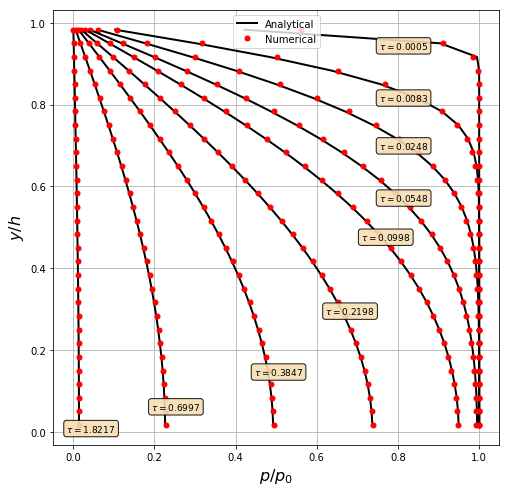

In [41]:
fig = plt.figure(figsize=(8,8))
ax1 = plt.subplot(111)

time_list = [3,15,25,35,50,90,145,250,624] # evaluation times

for graph in time_list:  
    ax1.plot(ter_sol['p_dim'][graph],
             g.cell_centers[1][::Nx]/Ly,
             '-k', linewidth = 2)
    ax1.plot(sol['pressure'][graph][int(Nx/2)::Nx]/(F_load),
             g.cell_centers[1][0::Nx]/Ly,
             'or', markersize = 5, linewidth = 1)         

ax1.plot([],[],'-k',linewidth=2,label = 'Analytical')
ax1.plot([],[],'or',markersize=5,label = 'Numerical')

# Adding texts
text_pos = [[0.73,0.93],[0.73,0.81],[0.73,0.70],[0.73,0.58],[0.69,0.49],
            [0.61,0.32],[0.45,0.18],[0.22,0.10],[0.03,0.05]]
for i in range(9):
    textstr = r'$\tau=%.4f$' % ter_sol['t_dim'][time_list[i]]    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.9)
    ax1.text(text_pos[i][0],text_pos[i][1], textstr, transform=ax1.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)  

# Put a legend to the right of the current axis
ax1.legend(loc='upper center')

# Put axis labels
ax1.set_xlabel(r'$p/p_0$',size=16)
ax1.set_ylabel(r'$y/h$',size=16)
ax1.grid(True)  

### Degree of consolidation vs time

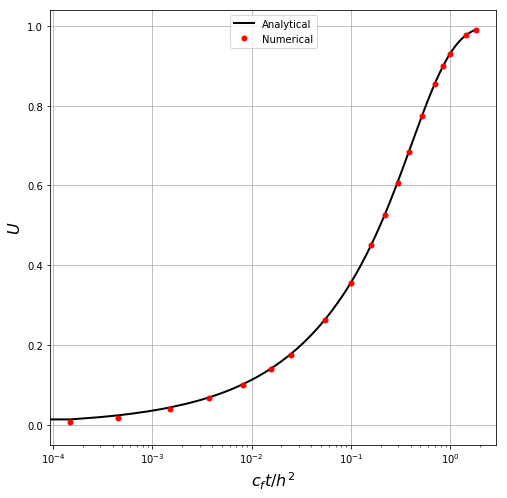

In [39]:
fig = plt.figure(figsize=(8,8))
ax2 = plt.subplot(111)
time_list = [1,3,7,10,15,20,25,35,50,70,90,115,145,190,250,300,350,500,624]
ax2.semilogx(ter_sol['t_dim'],
             ter_sol['U'],
             '-k', linewidth = 2, 
             label = 'Analytical')
for graph in time_list:
     ax2.semilogx(ter_sol['t_dim'][graph],
                 np.max(np.abs(sol['displacement_faces'][graph][1::2]))/u_inf,
                 'or',markersize=5)
ax2.plot([],[],'or',markersize=5, label= 'Numerical')

ax2.legend(loc='upper center')
ax2.set_xlabel(r'$c_f t / h^2$',size=16)
ax2.set_ylabel(r'$U$',size=16)
ax2.grid(True)  

## References
<a id='ref'></a>

[1]: *von Terzaghi, K. (1923). Die berechnung der durchassigkeitsziffer des tones aus dem verlauf der hydrodynamischen spannungs. erscheinungen. Sitzungsber. Akad. Wiss. Math. Naturwiss. Kl. Abt. 2A, 132, 105-124.*

[2]: *von Terzaghi, K. (1944). Theoretical Soil Mechanics.*

[3]: *Verruijt, A. (2017). An Introduction to Soil Mechanics (Vol. 30). Springer.*